In [1237]:
import json
import matplotlib.pyplot as plt
import numpy as np
import math

In [1238]:
def importData(file):

    # open json file
    with open(file) as f:
        data = json.load(f)

    keys = [i for i in data.keys()]

    d_vectors = {}
    good_dict = {}

    for key in keys:

        d_vectors[key] = {}
        vectors = data[key]["vectors"]

        measurement = data[key]["attributes"]["measurement"]
        repetition = data[key]["attributes"]["repetition"]
        configs = data[key]["config"]
        mergedConfigs={}
        for config in configs:
            mergedConfigs.update(config)
        timeLimit = mergedConfigs["sim-time-limit"]

        d_vectors[key]["measurement"] = measurement
        d_vectors[key]["repetition"] = int(repetition)
        
        assert timeLimit.endswith('s'), "Time limit format is incorrect"
        timeLimit = timeLimit[:-1]  # Remove the 's' at the end
        d_vectors[key]["timeLimit"] = int(timeLimit)

        if not measurement in good_dict:
            good_dict[measurement] = []

        good_dict[measurement].append({})
        good_dict[measurement][-1]['repetition']=int(repetition)
        good_dict[measurement][-1]['timeLimit']=int(timeLimit)
        good_dict[measurement][-1]['modules']={}

        for a in vectors:

            module = a["module"]
            name = a["name"]

            if not module in d_vectors[key]:
                d_vectors[key][module] = {}

            if not module in good_dict[measurement][-1]['modules']:
                good_dict[measurement][-1]['modules'][module] = {}

            d_vectors[key][module][name] = {}

            d_vectors[key][module][name]["times"] = a["time"]
            d_vectors[key][module][name]["values"] = a["value"]

            good_dict[measurement][-1]['modules'][module][name] = {}
            good_dict[measurement][-1]['modules'][module][name]["times"] = a["time"]
            good_dict[measurement][-1]['modules'][module][name]["values"] = a["value"]



    return d_vectors,good_dict


d_vectors,good_dict = importData("../multicore_sched/simulations/test.json")

In [1239]:
firstIndex=list(d_vectors)[0]

In [1240]:
firstIndex=list(d_vectors)[0]
print(d_vectors[firstIndex]['Computer.scheduler'].keys())

dict_keys(['turnaroundTime:vector', 'turnaroundTime:vector(mean)'])


In [1241]:
iterationvars=['meanGenerationTime','meanProcessDuration']
statistic='turnaroundTime:vector'

In [1242]:
measurements=[]
numRepetitions=0

for key in d_vectors:

    measurement=d_vectors[key]['measurement']
    repetition=d_vectors[key]['repetition']

    if not measurement in measurements:
        measurements.append(measurement)
    
    numRepetitions=max(numRepetitions,repetition+1)

In [1243]:
import colorsys

def getColors(numColors, numVariations):
    colors = []
    for i in range(numColors):
        base_hue = i / numColors  # Base hue for this color group
        colors.append([])
        for j in range(numVariations):
            # Introduce hue variation (±2.5% maximum from base hue)
            hue_variation = 0.2  # Adjust this value to control hue variation strength
            hue = (base_hue + ((j/numVariations) - 0.5) * hue_variation) % 1
            
            # Original brightness progression with modified parameters
            lightness = 0.4 + j/numVariations/2.5  # 0.4 to 0.8 lightness range
            saturation = 0.8 - j/numVariations/4  # 0.7 to 0.45 saturation range
            
            colors[i].append(colorsys.hls_to_rgb(
                hue, 
                lightness, 
                saturation
            ))
    return colors

# Usage remains the same
numColors = len(measurements)
numVariations = numRepetitions
colors = getColors(numColors, numVariations)

In [1244]:
def showColors():
    # Plot colors
    fig, ax = plt.subplots(figsize=(numVariations, numColors))
    for i, row in enumerate(colors):
        for j, color in enumerate(row):
            ax.add_patch(plt.Rectangle((j, i), 1, 1, color=color))

    ax.set_xlim(0, numVariations)
    ax.set_ylim(0, numColors)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
    plt.show()
# showColors()

In [1245]:
def measurementLabel(measurement, endline=True):
    for j, iterationvar in enumerate(iterationvars):
        measurement = measurement.replace(f"${j}", f"{iterationvar}")
    if endline:
        measurement = measurement.replace(', ', '\n')
    return measurement

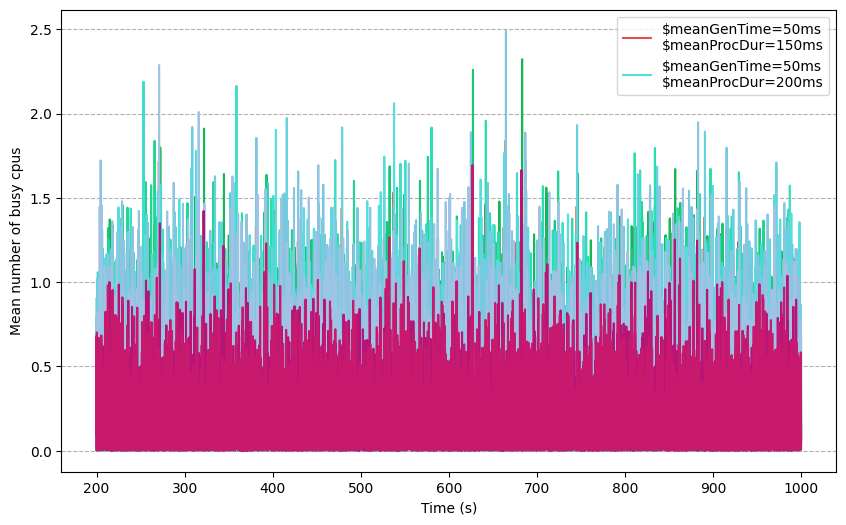

In [1246]:
for key in d_vectors:

    measurement=d_vectors[key]['measurement']
    repetition=d_vectors[key]['repetition']
    timeLimit=d_vectors[key]['timeLimit']

    color=colors[measurements.index(measurement)][repetition]

    times = d_vectors[key]["Computer.scheduler"][statistic]["times"]
    values = d_vectors[key]["Computer.scheduler"][statistic]["values"]

    plt.plot(times, values,color=color)

# Plt labels
for i, measurement in enumerate(measurements):
    plt.plot([], [], color=colors[i][numVariations//2], label=f'{measurementLabel(measurement)}')

# plt.xlim(0, 1000)

plt.xlabel('Time (s)')
plt.ylabel('Mean number of busy cpus')
plt.legend(loc='upper right', framealpha=0.8)
plt.gcf().set_size_inches(10, 6)
plt.grid(True, axis='y', which='both', linestyle='--')
# plt.xscale('log')
plt.show()

In [1247]:

def avg_and_std(values):
    average = np.average(values)
    # Biased variance
    variance = np.average((values-average)**2)
    return (average, np.sqrt(variance))

def weighted_avg_and_std(values, weights):
    average = np.average(values, weights=weights)
    # Biased variance
    variance = np.average((values-average)**2, weights=weights)
    return (average, np.sqrt(variance))

def find_nearest_small_value(key, sorted_li):
    less=[i for i in sorted_li if i <= key]
    if len(less)==0:
        return 0
    else:
        return len(less)-1

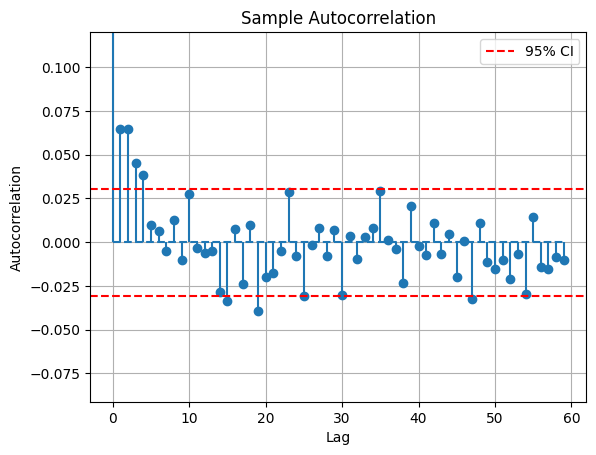

h: 30, Q: 82.07141838090364
Outside interval: 69, 1.6891064871481027%
Outside interval: 8, 8.080808080808081%
Now the number of samples is: 4086


In [1396]:
def autocorrelation(sample):
    # Step 1: Compute the mean and standard deviation
    mean = np.mean(sample)
    std_dev = np.std(sample)
    
    # Step 2: Normalize the sample
    normalized_sample = (sample - mean) / std_dev
    
    # Step 3: Compute the autocorrelation using numpy.correlate
    autocorr = np.correlate(normalized_sample, normalized_sample, mode='full')
    
    # The result is symmetric, so we take the second half
    autocorr = autocorr[len(autocorr)//2:]
    
    # Normalize the autocorrelation values
    autocorr /= autocorr[0]
    
    return autocorr

names=["$meanGenTime=50ms, $meanProcDur=150ms","$meanGenTime=50ms, $meanProcDur=200ms"]

testToUse=names[1]

statistic='turnaroundTime:vector'

values = good_dict[testToUse][0]['modules']["Computer.scheduler"][statistic]["values"]

p=1/2**2

new_values=[]

for value in values:
    rand=np.random.uniform()
    if rand<p:
        new_values.append(value)

values=new_values


avg, std = avg_and_std(values)

# Calculate autocorrelation
autocorr_values = autocorrelation(values)

stop=60
lags=range(0,stop)

plt.stem(lags,autocorr_values[0:stop],basefmt="--")  # Stem plot for autocorrelation
plt.title(f"Sample Autocorrelation")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")

# plt.ylim(top=max(autocorr_values[1:]*1.2))
plt.ylim(top=0.12)


# Add horizontal lines at ±1.96/sqrt(n)
n = len(values)  # Sample size
confidence_interval = 1.96 / np.sqrt(n)
plt.axhline(y=confidence_interval, color='r', linestyle='--', label='95% CI')
plt.axhline(y=-confidence_interval, color='r', linestyle='--')

plt.grid(True)
plt.legend()
plt.show()


#Ljung–Box test

h=30

Q=0
n=len(values)

for i in range(1,h):
    Q+=n*(n+2)*(autocorr_values[i]**2)/(n-i)

print(f"h: {h}, Q: {Q}")

# Calculate number of values outside confidence interval

outside=0


test_values=autocorr_values[1:]

for value in test_values:
    if value > confidence_interval or value < -confidence_interval:
        outside+=1

print(f"Outside interval: {outside}, {100*outside/len(test_values)}%")

# Calculate number of values outside confidence interval near

outside=0
stop=100

test_values=autocorr_values[1:stop]

for value in test_values:
    if value > confidence_interval or value < -confidence_interval:
        outside+=1

print(f"Outside interval: {outside}, {100*outside/len(test_values)}%")

print(f"Now the number of samples is: {len(values)}")

In [1439]:
from statsmodels.stats.diagnostic import acorr_ljungbox

acorr_ljungbox(values, lags=30, return_df=True)



def statsModelIndependence(values):
    Q,pvalue=acorr_ljungbox(values, lags=[30]).iloc[0]
    return Q,pvalue

def testIndependence(values,sigLevel=0.05):
    Q,pvalue=statsModelIndependence(values)
    return pvalue>sigLevel
testIndependence(values)


def makeValuesIndependent(values):
    k=0
    j=0

    testvalues=values.copy()

    while not testIndependence(testvalues):

        j+=1

        if j==3:
            k+=1
            j=0
        p=1/2**k

        testvalues=[]

        for value in values:
            rand=np.random.uniform()
            if rand<p:
                testvalues.append(value)

    return testvalues

testvalues=makeValuesIndependent(values)




In [1440]:
names=["$meanGenTime=50ms, $meanProcDur=150ms","$meanGenTime=50ms, $meanProcDur=200ms"]



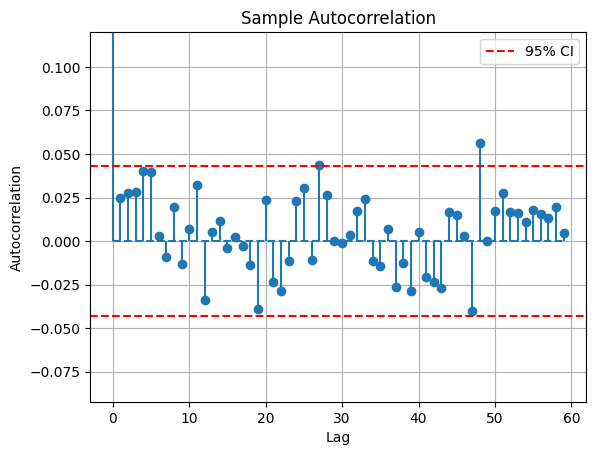

In [1444]:
testToUse=names[1]

statistic='turnaroundTime:vector'

values = good_dict[testToUse][0]['modules']["Computer.scheduler"][statistic]["values"]

values= makeValuesIndependent(values)

avg, std = avg_and_std(values)

# Calculate autocorrelation
autocorr_values = autocorrelation(values)

stop=60
lags=range(0,stop)

plt.stem(lags,autocorr_values[0:stop],basefmt="--")  # Stem plot for autocorrelation
plt.title(f"Sample Autocorrelation")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")

# plt.ylim(top=max(autocorr_values[1:]*1.2))
plt.ylim(top=0.12)


# Add horizontal lines at ±1.96/sqrt(n)
n = len(values)  # Sample size
confidence_interval = 1.96 / np.sqrt(n)
plt.axhline(y=confidence_interval, color='r', linestyle='--', label='95% CI')
plt.axhline(y=-confidence_interval, color='r', linestyle='--')

plt.grid(True)
plt.legend()
plt.show()

